In [77]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# XGBoost 

Set up cross validation, model creation functions and model tuning 

In [78]:
import numpy as np
import pandas as pd
import xgboost as xgb

import warnings
warnings.simplefilter('ignore')

## Load Data

In [79]:
train_df = pd.read_csv('../../data/raw/training.csv', index_col=0)
# train_df.replace(-1, np.nan, inplace=True)

test_df = pd.read_csv('../../data/raw/test.csv', index_col=0)
# test_df.replace(-1, np.nan, inplace=True)

train_df.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8_1,Q8_2,Q8_3,...,Q17,Q18,Q19,Latitude,Longitude,mobile_money,savings,borrowing,insurance,mobile_money_classification
ID,,,,,,,,,,,,,,,,,,,,,
5086,98,2,3,1,1,2,2,0,0,0,...,-1,4,4,-4.460442,29.811396,0,0,0,0,0
1258,40,1,1,3,5,1,1,1,0,0,...,4,1,4,-6.176438,39.244871,1,1,1,0,3
331,18,2,4,6,3,2,1,0,0,0,...,-1,1,1,-6.825702,37.652798,1,0,0,0,2
6729,50,1,1,3,1,1,1,0,0,0,...,-1,1,4,-3.372049,35.808307,1,0,1,0,3
8671,34,1,1,1,1,2,1,0,1,0,...,-1,1,4,-7.179645,31.039095,1,1,0,1,3


In [80]:
from glob import glob

train_features = glob('../../data/modelling/train/*.csv')
test_features = glob('../../data/modelling/test/*.csv')

train_features_df = pd.concat([pd.read_csv(f, index_col=0).fillna(-1) for f in train_features], axis=1)
test_features_df = pd.concat([pd.read_csv(f, index_col=0).fillna(-1) for f in test_features], axis=1)

train_features_df.head()

,atm_dist_closest,atm_deposits,atm_withdrawals,atm_bill_payment,atm_airtime,atm_bank_type,atm_years_old,atm_n_closest,mm_dist_closest,mm_tigo,mm_airtel,mm_m_pesa,mm_ezy_pesa,mm_loans,mm_insurance,mm_total_withdrawals,mm_total_deposits,mm_wdraw_dep_ratio,mm_n_closest_10_km
ID,,,,,,,,,,,,,,,,,,,
5086,45.146796,-1,Yes,-1,-1,Community Bank ATM,7,0,3.137028,-1,-1,Yes,-1,-1,-1,4.0,6.0,0.666667,12.0
1258,2.219941,-1,Yes,-1,-1,UMOJA SWITCH ATM,9,4,1.025637,Yes,-1,-1,-1,-1,-1,20.0,40.0,0.500000,278.0
331,1.004069,-1,Yes,-1,-1,Commercial Bank ATM,17,21,0.123305,Yes,Yes,Yes,-1,-1,-1,30.0,36.0,0.833333,781.0
6729,6.278241,-1,Yes,-1,-1,Commercial Bank ATM,14,0,0.025663,-1,Yes,Yes,-1,-1,-1,59.0,67.0,0.880597,61.0
8671,30.747110,-1,Yes,Yes,Yes,Commercial Bank ATM,10,0,6.587306,-1,-1,Yes,-1,-1,-1,35.0,23.0,1.521739,2.0


In [81]:
train_data = pd.concat([train_df, train_features_df], axis=1)
test_data = pd.concat([test_df, test_features_df], axis=1)

print(train_data.shape)
train_data.head()

(7094, 55)


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8_1,Q8_2,Q8_3,...,mm_tigo,mm_airtel,mm_m_pesa,mm_ezy_pesa,mm_loans,mm_insurance,mm_total_withdrawals,mm_total_deposits,mm_wdraw_dep_ratio,mm_n_closest_10_km
ID,,,,,,,,,,,,,,,,,,,,,
5086,98,2,3,1,1,2,2,0,0,0,...,-1,-1,Yes,-1,-1,-1,4.0,6.0,0.666667,12.0
1258,40,1,1,3,5,1,1,1,0,0,...,Yes,-1,-1,-1,-1,-1,20.0,40.0,0.500000,278.0
331,18,2,4,6,3,2,1,0,0,0,...,Yes,Yes,Yes,-1,-1,-1,30.0,36.0,0.833333,781.0
6729,50,1,1,3,1,1,1,0,0,0,...,-1,Yes,Yes,-1,-1,-1,59.0,67.0,0.880597,61.0
8671,34,1,1,1,1,2,1,0,1,0,...,-1,-1,Yes,-1,-1,-1,35.0,23.0,1.521739,2.0


In [82]:
X = train_data.drop(['mobile_money','savings','borrowing','insurance','mobile_money_classification'], axis=1)
y = train_data['mobile_money_classification']

print(X.shape)
X.head()

(7094, 50)


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8_1,Q8_2,Q8_3,...,mm_tigo,mm_airtel,mm_m_pesa,mm_ezy_pesa,mm_loans,mm_insurance,mm_total_withdrawals,mm_total_deposits,mm_wdraw_dep_ratio,mm_n_closest_10_km
ID,,,,,,,,,,,,,,,,,,,,,
5086,98,2,3,1,1,2,2,0,0,0,...,-1,-1,Yes,-1,-1,-1,4.0,6.0,0.666667,12.0
1258,40,1,1,3,5,1,1,1,0,0,...,Yes,-1,-1,-1,-1,-1,20.0,40.0,0.500000,278.0
331,18,2,4,6,3,2,1,0,0,0,...,Yes,Yes,Yes,-1,-1,-1,30.0,36.0,0.833333,781.0
6729,50,1,1,3,1,1,1,0,0,0,...,-1,Yes,Yes,-1,-1,-1,59.0,67.0,0.880597,61.0
8671,34,1,1,1,1,2,1,0,1,0,...,-1,-1,Yes,-1,-1,-1,35.0,23.0,1.521739,2.0


### Select 10% for independent testing

In [83]:
from sklearn.model_selection import train_test_split

X, X_test, y, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=420)

print(X.shape)
print(X_test.shape)

(6384, 50)
(710, 50)


## Create XBoost Model

In [84]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import log_loss
from xgboost.sklearn import XGBClassifier

seed = 2019

np.random.seed(seed)

n_classes = y.nunique()

# Params that won't be changed
static_params = {
    'objective': 'multi:softprob', #multiclass classification, but output probabilities not classes
    'num_class': 4,
    'eval_metric': 'mlogloss',
    'seed': 2019
}

# Some default params to start with
starter_params = {
    'n_estimators': 500,
    'max_depth': 5,
    'gamma': 0,
    'min_child_weight': 1,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'scale_pos_weight': 1
}
# Combine parameters sets into one
xgb_params = {**static_params, **starter_params}
xgb_params.update(starter_params)

### Create Preprocessing and Feature Extraction Pipeline(s)

In [85]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder
from src.features.transformers import ColumnExtractor, MMAgentsInVicinity
from fastai.tabular import cont_cat_split

from category_encoders import BinaryEncoder

CONT_VARS, CAT_VARS = cont_cat_split(X)
LAT_LON = ['Latitude','Longitude']

print('\nCONT VARS:', CONT_VARS)
print("\nCAT VARS:", CAT_VARS)


CONT VARS: ['Q1', 'Latitude', 'Longitude', 'atm_dist_closest', 'atm_years_old', 'atm_n_closest', 'mm_dist_closest', 'mm_total_withdrawals', 'mm_total_deposits', 'mm_wdraw_dep_ratio', 'mm_n_closest_10_km']

CAT VARS: ['Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8_1', 'Q8_2', 'Q8_3', 'Q8_4', 'Q8_5', 'Q8_6', 'Q8_7', 'Q8_8', 'Q8_9', 'Q8_10', 'Q8_11', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'atm_deposits', 'atm_withdrawals', 'atm_bill_payment', 'atm_airtime', 'atm_bank_type', 'mm_tigo', 'mm_airtel', 'mm_m_pesa', 'mm_ezy_pesa', 'mm_loans', 'mm_insurance']


In [86]:
from sklearn_pandas import DataFrameMapper, gen_features
from category_encoders import OneHotEncoder

# Continuous feature maps
con_maps = gen_features(
    columns=[[c] for c in CONT_VARS], 
#     classes=[{'class': KBinsDiscretizer, 'n_bins': 7, 'encode': 'onehot-dense'}]
)

# Categorical Feature maps
# Just select the columns for now
cat_maps = gen_features(
    columns=[[c] for c in CAT_VARS],
    classes=[{'class': OneHotEncoder}])

# Location Feature maps
# loc_maps = [
#     (LAT_LON, MMAgentsInVicinity(radius=5), {'alias': 'mobile_money_agents'})
# ]

feature_maps = con_maps + cat_maps

features_pipeline = DataFrameMapper(feature_maps, df_out=True)

## Train Basic Model

In [87]:
def score_model(model, X_test, y_test):
    probs = model.predict_proba(X_test)
    score = log_loss(y_test, probs)
    return score

In [88]:
X_proc = features_pipeline.fit_transform(X)

X_test_proc = features_pipeline.transform(X_test)

X_proc.head()

,Q1,Latitude,Longitude,atm_dist_closest,atm_years_old,atm_n_closest,mm_dist_closest,mm_total_withdrawals,mm_total_deposits,mm_wdraw_dep_ratio,...,mm_airtel_0_1,mm_airtel_0_2,mm_m_pesa_0_1,mm_m_pesa_0_2,mm_ezy_pesa_0_1,mm_ezy_pesa_0_2,mm_loans_0_1,mm_loans_0_2,mm_insurance_0_1,mm_insurance_0_2
ID,,,,,,,,,,,,,,,,,,,,,
3734,17,-11.049130,34.761423,9.622785,14,0,4.278838,30.0,20.0,1.500000,...,1,0,1,0,1,0,1,0,1,0
524,62,-2.539368,32.912892,1.118049,10,34,0.328924,12.0,8.0,1.500000,...,1,0,1,0,1,0,1,0,1,0
3816,35,-3.809558,33.301002,18.806925,6,0,3.321010,17.0,15.0,1.133333,...,0,1,1,0,1,0,1,0,1,0
4439,50,-1.559780,31.644960,9.585202,17,0,4.296731,23.0,20.0,1.150000,...,1,0,1,0,1,0,1,0,1,0
579,38,-10.660069,35.656256,1.683394,18,6,0.104269,13.0,12.0,1.083333,...,1,0,1,0,1,0,1,0,1,0


In [89]:
%%time
model = XGBClassifier(missing=-1, **xgb_params)
model.fit(X_proc, y)

CPU times: user 45.3 s, sys: 55.2 ms, total: 45.3 s
Wall time: 45.4 s


## Evaluate

In [90]:
print("Log loss on held out test set: ", score_model(model, X_test_proc, y_test))

Log loss on held out test set:  0.764680787604171


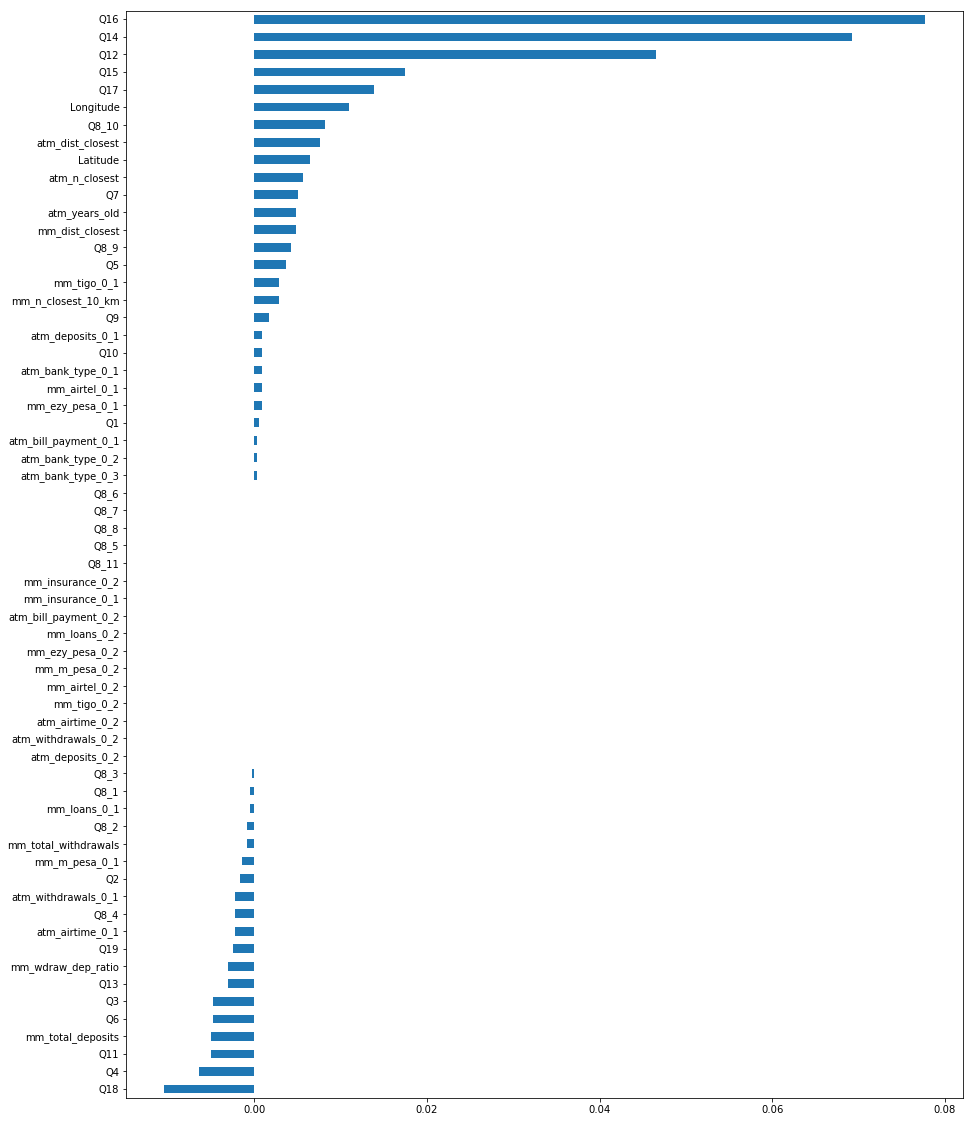

In [91]:
import matplotlib.pyplot as plt
import eli5

perm = eli5.sklearn.PermutationImportance(model, random_state=2019).fit(X_test_proc, y_test)

feat_imp = pd.Series(perm.feature_importances_, index=list(X_proc)).sort_values()
feat_imp.plot.barh(figsize=(15,20))

### Drop bad features and redo

In [92]:
features_to_keep = list(feat_imp[feat_imp > 0].index)

In [93]:
%%time
model = XGBClassifier(missing=-1, **xgb_params)
model.fit(X_proc[features_to_keep], y)

CPU times: user 23.8 s, sys: 40.4 ms, total: 23.9 s
Wall time: 23.9 s


In [94]:
score_model(model, X_test_proc[features_to_keep], y_test)

0.7685062756568429

In [96]:
model_improvement = 0.764680787604171 - 0.7685062756568429
model_improvement

-0.0038254880526719104

**Result**
By dropping those features model performance went down. 


## Hyper Parameter Tuning Using `skopt`

In [35]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, StratifiedKFold

from IPython.display import clear_output

class ConvergencePlotCallback(object):
    def __init__(self, figsize=(12,8)):
        self.fig = plt.figure(figsize=figsize)

    def __call__(self, res):
        clear_output(wait=True)
        plot_convergence(res)
        plt.show()
        
skf = StratifiedKFold(n_splits=5)
plot_callback = ConvergencePlotCallback(figsize=(12,8));

<Figure size 864x576 with 0 Axes>

In [42]:
space = [
    Integer(1, 5, name='max_depth'),
    Real(1e-5, 1, "log-uniform", name='learning_rate'),
    Integer(1, 5, name='min_child_weight'),
    Real(0.001, 4, "log-uniform", name='gamma'),
    Real(0.5, 1.0, "uniform", name="subsample"),
    Real(0.5, 1.0, "uniform", name='colsample_bytree'),
    Real(1e-5, 100, "log-uniform", name="reg_alpha")
]

@use_named_args(space)
def objective(**params):
    
    new_params = {**xgb_params}
    new_params.update(**params)
    
    model = XGBClassifier(**new_params)
    
    score = -np.mean(cross_val_score(model, X_proc, y, cv=skf, n_jobs=-1, scoring='neg_log_loss'))
    
    return score

def to_named_params(params, space=space):
    return({dimension.name: param for dimension, param in zip(space, params)})


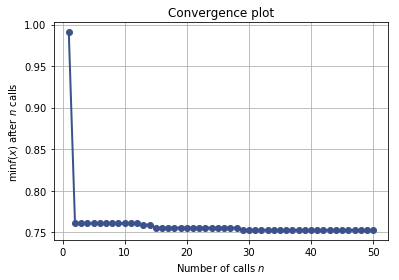

In [40]:
gp_results = gp_minimize(objective, space, n_calls=50, random_state=2019, callback=[plot_callback])

## Train model on optimum params

* Get optimum parameters
* Combine train and validation set
* Train on full dataset
* Predict on test data
* Make submission

In [101]:
best_params = to_named_params(gp_results.x)
opt_params = {**static_params, **best_params}

best_model = XGBClassifier(**opt_params)
best_model.fit(X_proc, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.5, eval_metric='mlogloss',
              gamma=0.08221364028943687, learning_rate=0.02544817809019885,
              max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
              n_estimators=100, n_jobs=1, nthread=None, num_class=4,
              objective='multi:softprob', random_state=0,
              reg_alpha=0.005705872369796133, reg_lambda=1, scale_pos_weight=1,
              seed=2019, silent=True, subsample=0.5)

In [105]:
best_model.classes_

array([0, 1, 2, 3])

## Inspect Predictions

### Create features from test data

In [ ]:
X_test_proc = preprocessing_pipeline.fit_transform(X_test)
X_test_proc = pd.DataFrame(X_test_proc, columns=features)
X_test_proc.head()

### Score Model

In [109]:
score = score_model(best_model, X_test_proc, y_test)
print("Log loss of optimized model on hold-out test set: ",score)

Log loss of optimized model on hold-out test set:  0.8425694594920521


### Confusion Matrix

In [102]:
from sklearn.metrics import confusion_matrix

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

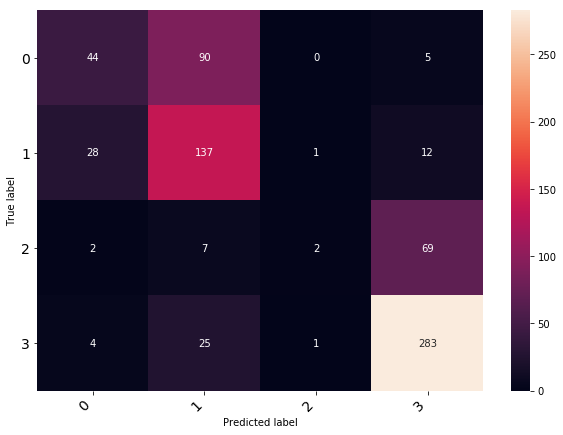

In [106]:
test_preds = best_model.predict(X_test_proc)

class_names = best_model.classes_

cm = confusion_matrix(y_test, test_preds)

plot = print_confusion_matrix(cm, class_names)

In [104]:
class_names

array([1, 3, 0, 2])

**Results**

I am misclassifying almost all customers in class 2 to be in class 3. From previous analysis I saw that we can predict whether someone uses mobile money or not very well, but some of the other classes were not so easy to predict. Soooo, it could be that I'm correctly predicting that these customers are using mobile money, but then incorrectly predicting that they are also using one other financial service.

**Class Descriptions**
* 0 no mobile money and no other financial service (saving, borrowing, insurance)
* 1 no mobile money, but at least one other financial service
* 2 mobile money only
* 3 mobile money and at least one other financial service


**Next Steps**

1. Get all the class 2 customers misclassified as class 3, and look at what financial services they actually use. 

## Make Submission

In [ ]:
X = pd.concat([X_proc, X_test_proc], axis=1)

In [ ]:
from src.utils import make_sub

In [ ]:
X_test = pd.read_csv('../../data/raw/test.csv', index_col=0)

X_test_proc = preprocessing_pipeline.transform(X_test)

In [ ]:
test_probs = best_model.predict_proba(X_test_proc)

sub_df = make_sub(test_probs)

sub_df.head()

In [ ]:
sub_df.to_csv('../../data/submissions/xgb_baseline_tuned.csv')